# Projet ST7 - Cyclone

La case ci-dessous permet d'importer l'ensemble des modules utilisés dans ce projet.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# Partie un
from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde
from sklearn.neighbors import NearestNeighbors, KDTree
import folium
# Partie deux
from itertools import product as iter_product
import seaborn as sns

## Pré-traitement de la base de données

In [17]:
data = pd.read_csv("Dataset/ibtracs_NA_list_v04r00.csv", delimiter=',', dtype=str, keep_default_na=False)
data = data[data['ISO_TIME'] > '1970-01-01 00:00:00']

print(data['BASIN'].value_counts())
NA_DATA = data[data['BASIN'] == 'NA']
NA_DATA[['LAT','LON']] = NA_DATA[['LAT','LON']].astype(float)
NA_DATA[['STORM_DIR','STORM_SPEED']] = NA_DATA[['STORM_DIR','STORM_SPEED']].astype(int)
coor = NA_DATA[['LAT','LON']][1::].astype('float')
LAT = np.array(coor['LAT'])
LON = np.array(coor['LON'])

initial_data = NA_DATA.groupby('SID').nth(0)
initial_data = initial_data[['ISO_TIME', 'LAT','LON']]
initial_coor = initial_data[['LAT','LON']][1::].astype('float')
initial_LAT = np.array(initial_coor['LAT'])
initial_LON = np.array(initial_coor['LON'])

initial_data.head()

NA    48355
EP      384
Name: BASIN, dtype: int64


C:\Users\noe\AppData\Local\Temp\ipykernel_20240\43741562.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NA_DATA[['LAT','LON']] = NA_DATA[['LAT','LON']].astype(float)
C:\Users\noe\AppData\Local\Temp\ipykernel_20240\43741562.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NA_DATA[['STORM_DIR','STORM_SPEED']] = NA_DATA[['STORM_DIR','STORM_SPEED']].astype(int)


ISO_TIME   LAT   LON
SID                                           
1970138N12281  1970-05-17 18:00:00  11.5 -79.0
1970200N19277  1970-07-19 00:00:00  18.5 -83.5
1970210N34285  1970-07-28 18:00:00  34.2 -74.8
1970212N18278  1970-07-31 00:00:00  18.5 -82.5
1970215N14342  1970-08-02 12:00:00  14.0 -18.0

## Initiation d’un cyclone

Les valeurs de latitude sont mesurées par rapport à l'équateur, les valeurs sont comprises entre -90° au pôle Sud et +90° au pôle Nord. Les valeurs de longitude sont mesurées par rapport au premier méridien. Elles sont comprises entre -180° en allant vers l'ouest et 180° vers l'est.

Quelques fonctions utilitaires permettront de fluidifier le code.

In [3]:
def getBins(LAT,LON,res=5):
    '''
    Utility function to get bins for custom histogram, with res=5
    '''
    bin_lat = np.arange((np.min(LAT) // res) * res, np.max(LAT) + res, res)
    bin_lon = np.arange((np.min(LON) // res) * res, np.max(LON) + res, res)
    return bin_lat, bin_lon

def getCoord(LAT,LON):
    coordinates = np.array(list(zip(LAT, LON)))
    return coordinates

def getCenters(LAT,LON,RES):
    '''
    Utility function to get centers for custom histogram
    '''
    bin_lat, bin_lon = getBins(LAT,LON,RES)
    centers = np.zeros((len(bin_lat)-1,len(bin_lon)-1,2))
    for i in range(len(bin_lat)-1):
        for j in range(len(bin_lon)-1):
            centers[i,j] = [bin_lat[i]+RES/2, bin_lon[j]+RES/2]
    return centers

def getHist(LAT,LON,RES):
    '''
    Utility function to get custom histogram
    '''
    bin_lat, bin_lon = getBins(LAT,LON,RES)
    print(bin_lat.shape,bin_lon.shape)
    hist, latedges, lonedges = np.histogram2d(LAT, LON, bins=(bin_lat, bin_lon))
    return hist/np.sum(hist), latedges, lonedges


def plotHist(hists, lat_edges,lon_edges, labels=None,relative=True):
    '''
    Utility function to plot custom histogram
    '''
    if labels==None:
        labels = [str(i) for i in range(len(hists))]
    if len(hists)==1:
        fig,axs = plt.subplots(1,1,figsize=(20,20))
        plt.imshow(hists[0], origin='lower', extent=[lon_edges[0], lon_edges[-1], lat_edges[0], lat_edges[-1]], cmap=plt.cm.jet)
        axs.set_title('Histogram ' + labels[0])
        plt.colorbar()
        plt.show()
    else:
        fig,axs = plt.subplots(1,len(hists),figsize=(20,20))
        for i in range(len(hists)):
            vmin, vmax = 0, hists[i*(not relative)].max()
            axs[i].imshow(hists[i], origin='lower', vmin=0,vmax=vmax, extent=[lon_edges[0], lon_edges[-1], lat_edges[0], lat_edges[-1]], cmap=plt.cm.jet)
            axs[i].set_title('Histogram '+labels[i])
        plt.show()
    return fig, axs

# Gaussian KDE computing

def applyGaussianKDE(LAT,LON, SIGMA=1, RESOLUTION=5):
    '''
    Function to apply Gaussian KDE to the histogram
    '''
    # start by collecting bins and the kernel
    bin_lat, bin_lon = getBins(LAT,LON,RESOLUTION)
    kernel = gaussian_kde(np.vstack([LAT, LON]),SIGMA)  
    size = (len(bin_lat),len(bin_lon))
    
    # fill in the histogram
    temp_hist = np.empty(size)
    for i_lat in range(size[0]):
        for j_lon in range(size[1]):
            center = [bin_lat[i_lat] + RESOLUTION / 2, bin_lon[j_lon] + RESOLUTION / 2]
            temp_hist[i_lat, j_lon] = kernel(center)
    return temp_hist/np.sum(temp_hist)

(10,) (19,)


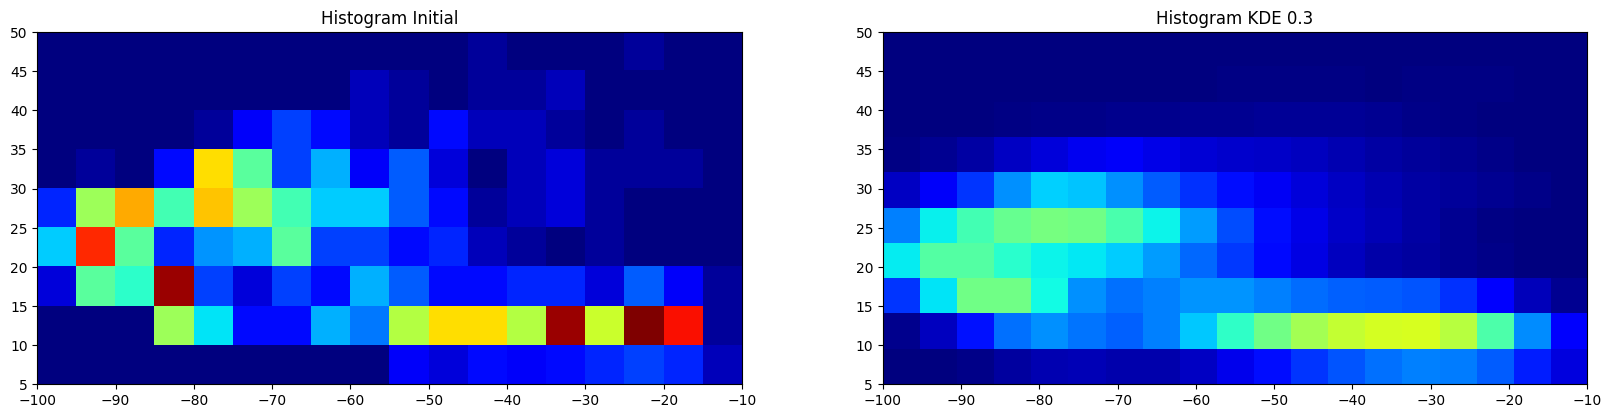

In [4]:
# Compute the initial histogram
hist_no_smoothing, lat_edges, lon_edges = getHist(initial_LAT,initial_LON,5)
hist_kde = applyGaussianKDE(initial_LAT,initial_LON,1/3)

_ = plotHist([hist_no_smoothing, hist_kde], lat_edges, lon_edges, labels=['Initial','KDE 0.3'])


Original max & min         :  0.04 0.0
Smoothing 0.2 max & min    :  0.03 0.0
Smoothing 0.4 max & min    :  0.02 0.0
Smoothing 0.6 max & min    :  0.02 0.0
Smoothing 0.8 max & min    :  0.01 0.0
Smoothing 1.0 max & min    :  0.01 0.0


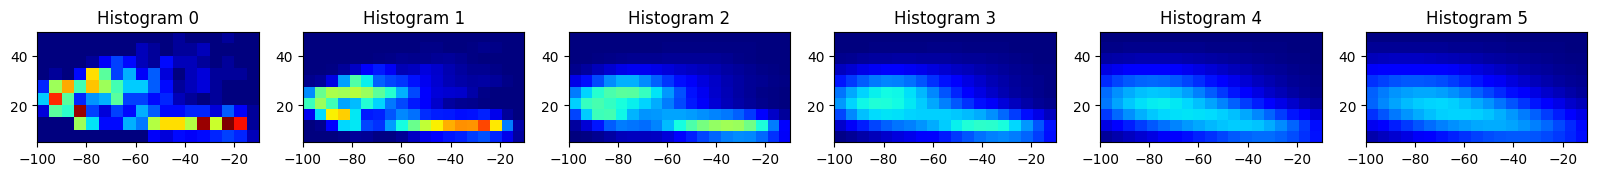

In [5]:
# We will now create all the histograms we wish to display
hists = [hist_no_smoothing]
print("Original max & min         : ", round(np.max(hist_no_smoothing),2),round(np.min(hist_no_smoothing),2))
for i in range(1,6):
    temp = applyGaussianKDE(initial_LAT,initial_LON,i/5)
    hists.append(temp)
    print("Smoothing {} max & min    : ".format(i/5), round(np.max(temp),2),round(np.min(temp),2))

_ = plotHist(hists, lat_edges, lon_edges, ["0", "1", "2", "3", "4", "5"])




### Interprétations : 

On détermine un kernel optimal de 0.4.

## Bonus

Quelques fonctions vont nous permettre de réaliser efficacement le bonus. 

In [6]:
# Utility function to get the distances between the cells
def computeSigmaMatrix(LAT=LAT,LON=LON,RES=5,centers=0):
    X = getCoord(initial_LAT,initial_LON)
    tree = KDTree(X, leaf_size=2)
    if type(centers)==int:
        centers = getCenters(LAT,LON,RES)
    sigma_t = np.zeros(centers.shape[:2])
    for i,j in np.ndindex(centers.shape[0],centers.shape[1]):
        sigma_t[i,j] = min([np.max([np.max(tree.query(centers[i,j].reshape(1, -1),k=3)[0]),1]),15])
    return sigma_t

# Utility function to get the new histogram
def getBonusHist(sze,centers,sigMat,RES=5,LAT=initial_LAT,LON=initial_LON):
    hist_bonus = np.empty(sze)
    bin_lat, bin_lon = getBins(LAT,LON,RES)
    for iLat,jLon in np.ndindex(hist_bonus.shape):
        lat = bin_lat[iLat] + RES / 2
        lon = bin_lon[jLon] + RES / 2
        kernel = gaussian_kde(np.vstack([LAT, LON]))
        hist_bonus[iLat, jLon] = kernel([lat, lon])
    return hist_bonus/(hist_bonus.max() - hist_bonus.min())



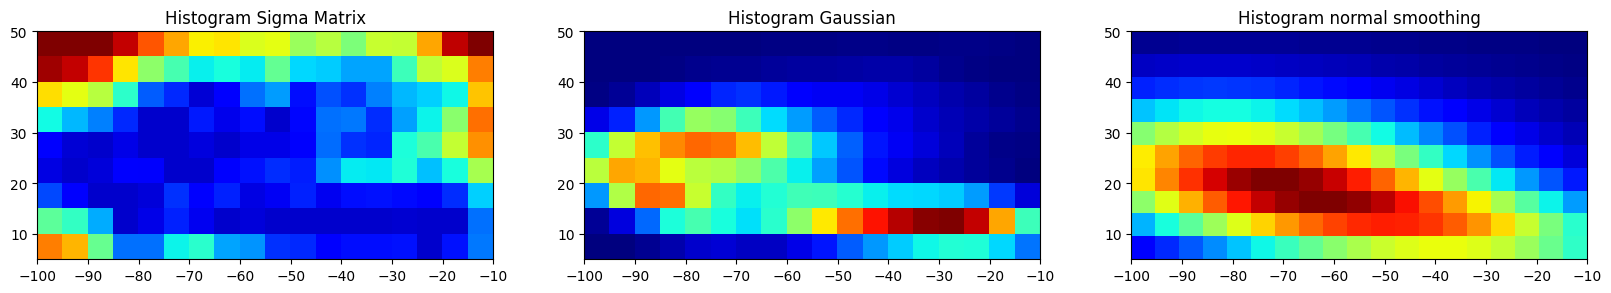

In [7]:
sigMat      = computeSigmaMatrix(initial_LAT,initial_LON,5)
hist_bonus  = getBonusHist(hist_no_smoothing.shape, getCenters(initial_LAT,initial_LON,5), sigMat)
_           = plotHist([sigMat,hist_bonus,applyGaussianKDE(initial_LAT,initial_LON,i/5)], lat_edges, lon_edges, labels=['Sigma Matrix', 'Gaussian','normal smoothing'],relative=False)


## Propagation d'un cyclone

Les variables d'états sont $(S_i, \theta_i)$ soit la vitesse et l'angle de propagation du cyclone. Ces informations permettent de retrouver la position à l'instant $i$ du cyclone mais aussi à l'instant $i+1$. 

Choisir $P(x_{i+1},y_{i+1}|x_{i},y_{i})$ ne donne accès qu'à l'information à un temps $t_i$, là où l'utilisation des vitesses et direction permet d'obtenir le déplacement d'un cyclone et donc sa position à $t+1$. Cela permet donc de prévoir les variations de mouvement d'un cyclone. De plus, récupérer la vitesse à partir des positions nécessite une plus grande quantité d'informations (pour calculer des vitesses à partir de positions) que l'utilisation des vitesses permet de prévenir.

Montrons rapidement que connaitre $(S,\theta)_{(1,n)}$ est équivalent à connaitre $(x,y)_{(1,n)}$.
- Avec $(x,y)_{(1,n)}$, on reconstruit facilement $S$ et $\theta$: $S=\sqrt{(x_{i+1}-x_i)^2+(y_{i+1}-y_i)^2}$ et $\theta = arctan(\frac{y_{i+1}-y_i}{x_{i+1}-x_i})$
- Avec $(S,\theta)_{(1,n)}$, étant donné l'information initiale ${x_0,y_0}$, on obtient aisément: $x_{i+1} = x_i + cos(\theta_i)$ et $y_{i+1} = y_i + cos(\theta_i)$

On a donc bien l'équivalence des deux quantités, dès l'instant que l'on connait la position initiale d'un cyclone.


In [8]:
def convert360To180(lona):
    '''
    Utility to convert the 0:360 scale to -180:180
    '''
    temp = []
    for lon in lona:
        if lon > 180:
            lon -=360
        temp.append(lon)
        
    return np.array(temp)

In [9]:
def getBinIndex(bins,value):
        index = 0
        for element in bins:
                if element<value:
                        index+=1
        return index

def N(res=3, event='STORM_SPEED',RAW=NA_DATA):
        '''
        Function to compute the number of cyclones in the dataset computing from E at t to E at t plus one
        '''
        EVENTS = RAW[event].astype(int)

        bin_event = np.arange((np.min(EVENTS) // res) * res, np.max(EVENTS) + res, res)

        mat = np.zeros((len(bin_event),len(bin_event)))

        for cyclone in RAW['SID'].unique():
                # For each cyclone, we add to the matrix in each position the proba of the next event
                cyc_event = np.array(RAW[RAW['SID']==cyclone][event].astype(int))
                for i0 in range(len(cyc_event)-1):
                        x,y = getBinIndex(bin_event,cyc_event[i0]), getBinIndex(bin_event,cyc_event[i0+1])
                        mat[x,y] += 1

        # We then need to normalize each column, by dividing by the sum of the column or 1 if it is empty
        normal = np.max([np.sum(mat, axis=1),[1]*mat.shape[0]],0)
        return mat / normal, bin_event

## Little test for the normalisation formula:
# temp = [[1,3,5],[10,3,4],[1,2,3]]
# temp = np.array(temp)
# print(temp)
# print(np.sum(temp, axis=0))
# print(temp/np.sum(temp, axis=0))

# mat, _ = N(res=3, event='STORM_DIR',RAW=data)
# plt.imshow(mat, cmap=plt.cm.jet, origin='lower')

On peut à présent enrichir la base de données et tracer les graphiques demandés.

Text(0, 0.5, '$S_{i+1}$')

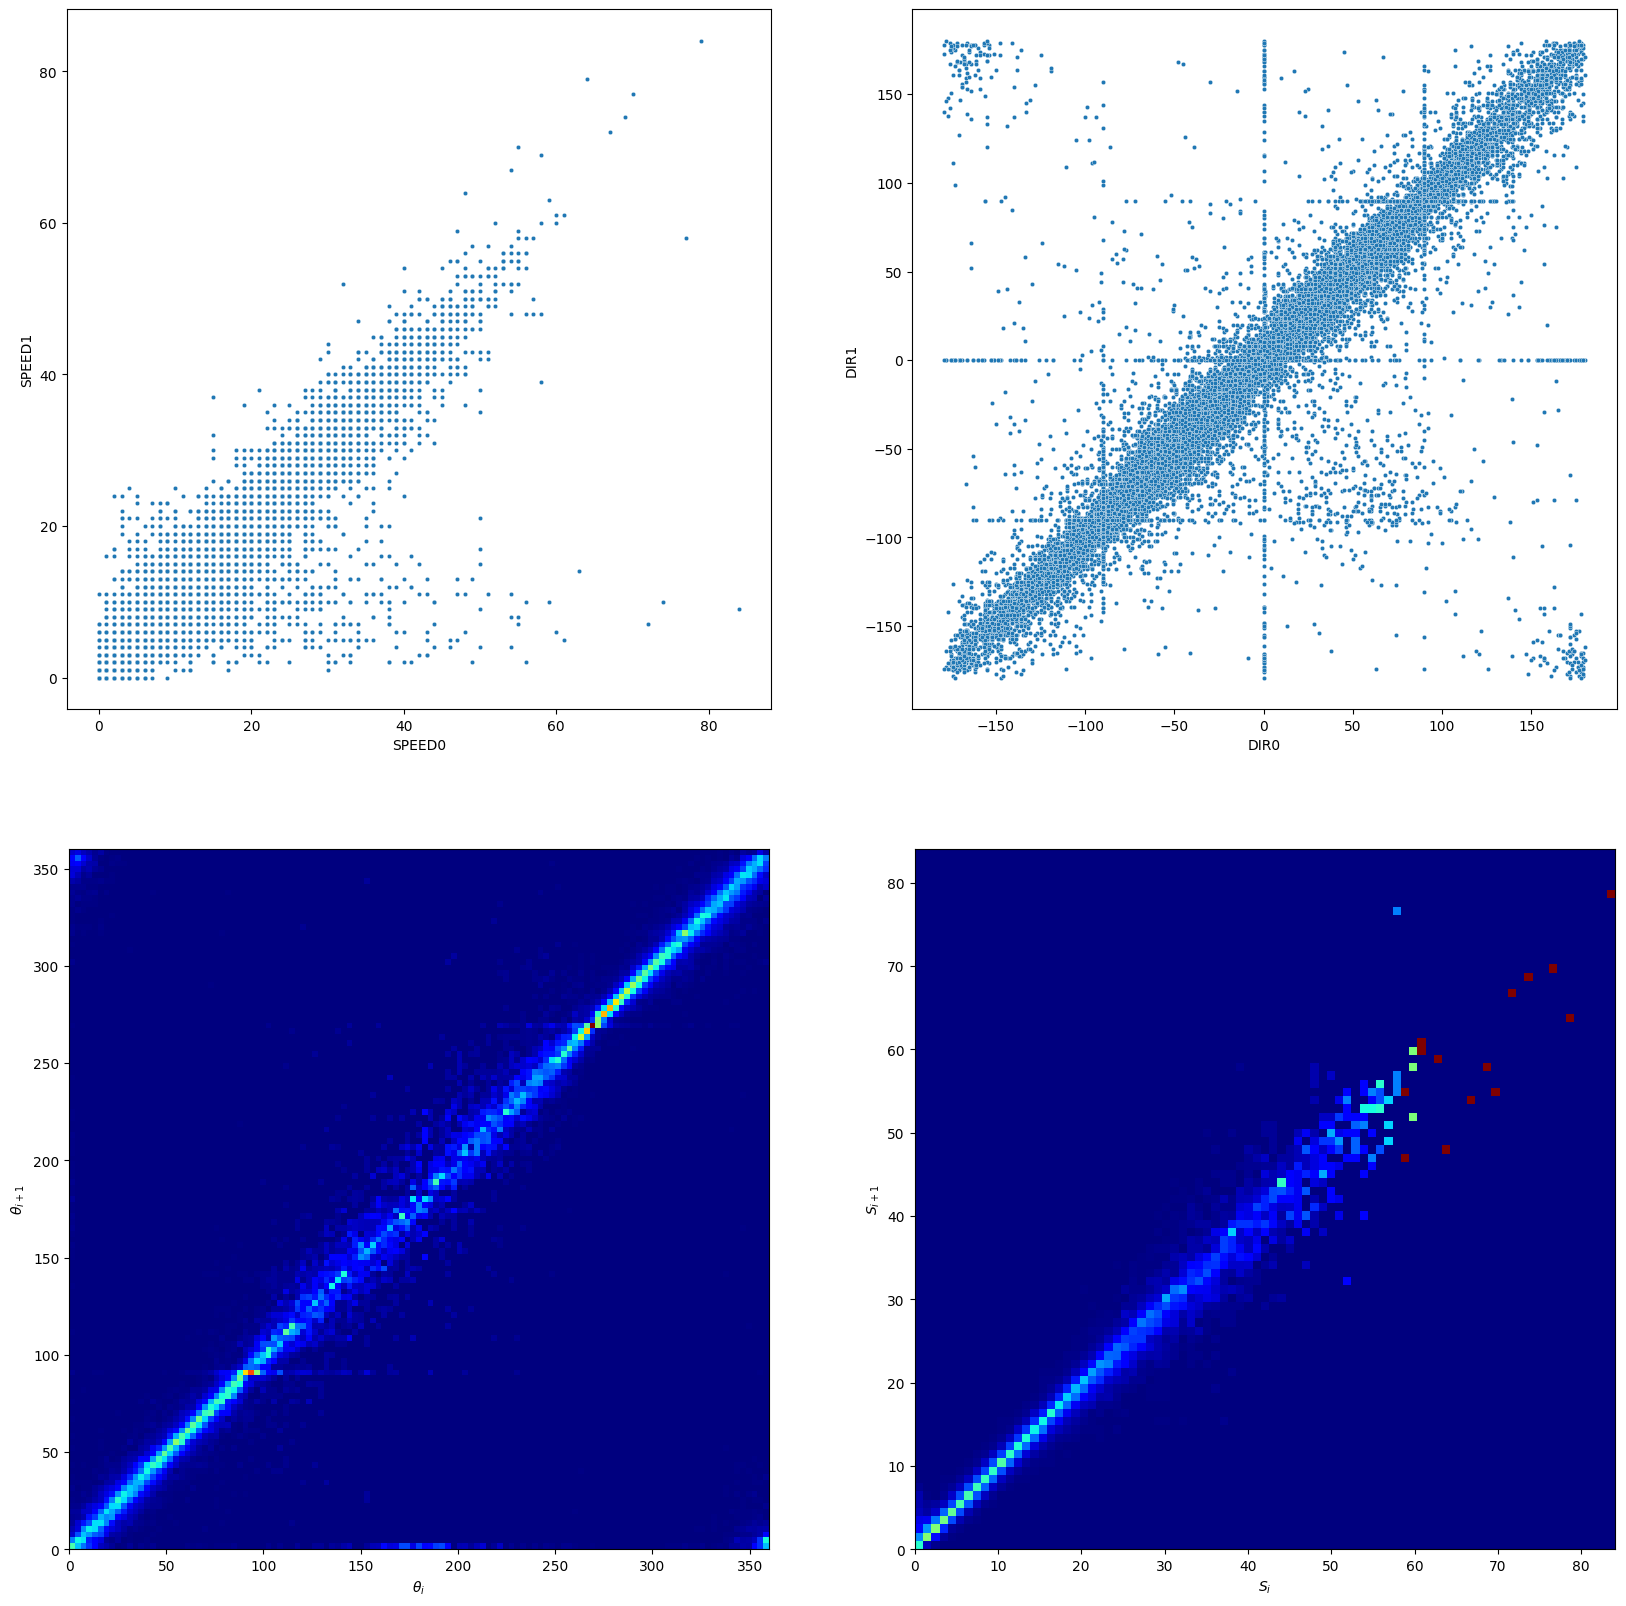

In [11]:
# NA_DATA = data[data['BASIN']=='NA'][['SID','LAT','LON','STORM_DIR','STORM_SPEED','ISO_TIME']]
# NA_DATA[['LAT','LON']] = NA_DATA[['LAT','LON']].astype(float)
# NA_DATA[['STORM_DIR','STORM_SPEED']] = NA_DATA[['STORM_DIR','STORM_SPEED']].astype(int)

fig, axes = plt.subplots(2, 2, figsize=(20, 20))


der_df = pd.DataFrame()
der_df["SPEED0"] = list(NA_DATA["STORM_SPEED"].astype(int)[0:-1])
der_df["SPEED1"] = list(NA_DATA["STORM_SPEED"].astype(int)[1::])
der_df["DIR0"] = convert360To180(NA_DATA["STORM_DIR"].astype(int)[0:-1])
der_df["DIR1"] = convert360To180(NA_DATA["STORM_DIR"].astype(int)[1::])

# Speed and direction plots
sns.scatterplot(x="SPEED0",y="SPEED1",data=der_df,ax=axes[0,0], s=10)
sns.scatterplot(x="DIR0",y="DIR1",data=der_df,ax=axes[0,1], s=10)
axes[1,0].set_xlabel('Speed at t+1 as a function of speed at t')
axes[1,1].set_xlabel('Direction at t+1 as a function of direction at t')

mat, bin = N(RAW=NA_DATA, res=3, event='STORM_DIR')
axes[1,0].imshow(mat, origin='lower', cmap=plt.cm.jet, extent=[min(bin),max(bin),min(bin),max(bin)])
axes[1,0].set_xlabel(r"$\theta_i$")
axes[1,0].set_ylabel(r"$\theta_{i+1}$")

mat, bin = N(RAW=NA_DATA, res=1, event='STORM_SPEED')
axes[1,1].imshow(mat, origin='lower', cmap=plt.cm.jet, extent=[min(bin),max(bin),min(bin),max(bin)])
axes[1,1].set_xlabel(r"$S_i$")
axes[1,1].set_ylabel(r"$S_{i+1}$")

Montrons que $\dot{S}$ et $\dot{\theta}$ sont équivalents à $S$ et $\theta$.
- Supposons $(S,\theta)_{(1,n)}$ connu. Alors, on obtient aisément $(\dot{S},\dot{\theta})_{(1,n-1)}$ en appliquant la définition de ses deux quantités
- Supposons inversement que $(\dot{S},\dot{\theta})_{(1,n-1)}$ est connu. Alors, à l'aide de l'information initiale $(S,\theta)_{0}$
Modulo la connaissance d'une condition initiale, les deux vecteurs sont donc équivalentes.

In [18]:
# Let's start by enriching NA_DATA with the previous and next speed and direction
temp_speed_d    = []
temp_dir_d      = []
for cyclone in NA_DATA['SID'].unique():
    temp_speed_d    +=list(NA_DATA[NA_DATA['SID']==cyclone]['STORM_SPEED'].shift(-1)-NA_DATA[NA_DATA['SID']==cyclone]['STORM_SPEED'])
    temp_dir_d      +=list(NA_DATA[NA_DATA['SID']==cyclone]['STORM_DIR'].shift(-1)-NA_DATA[NA_DATA['SID']==cyclone]['STORM_DIR'])

temp_speed_d
NA_DATA['SPEED_P'] = temp_speed_d
NA_DATA['DIR_P'] = temp_dir_d

C:\Users\noe\AppData\Local\Temp\ipykernel_20240\4032104688.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NA_DATA['SPEED_P'] = temp_speed_d
C:\Users\noe\AppData\Local\Temp\ipykernel_20240\4032104688.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NA_DATA['DIR_P'] = temp_dir_d


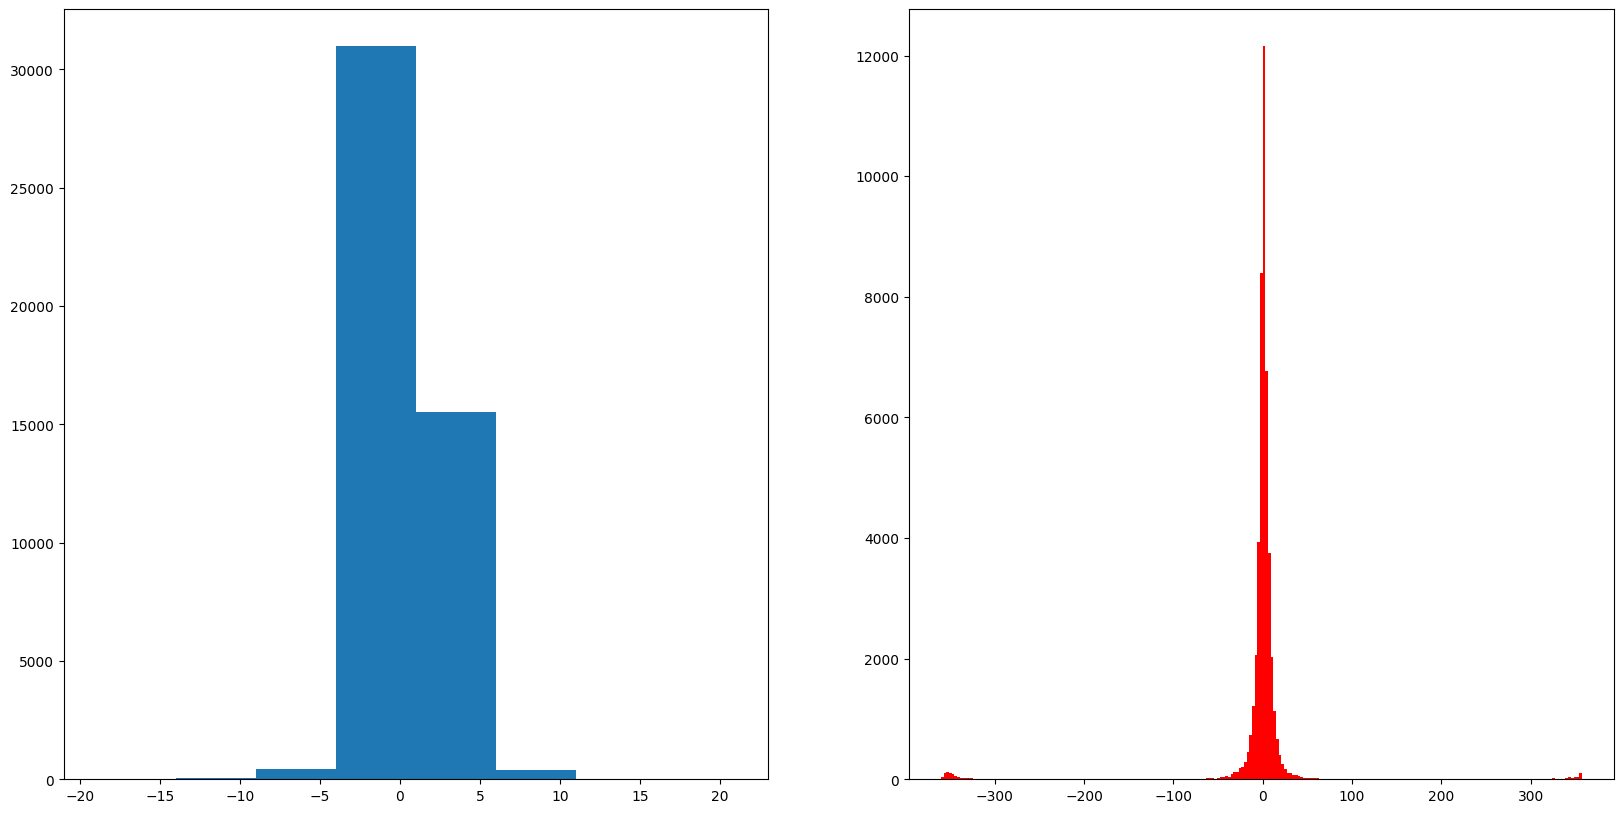

In [19]:
fig, ax= plt.subplots(1,2,figsize=(20,10))
_ =ax[0].hist(NA_DATA['SPEED_P'],bins=np.arange(min(NA_DATA['SPEED_P']),max(NA_DATA['SPEED_P']),5))
_=ax[1].hist(NA_DATA['DIR_P'],bins=np.arange(min(NA_DATA['DIR_P']),max(NA_DATA['DIR_P']),3),color='r')

In [ ]:
def N2_SPEED(RAW, res=5):
    '''
    Function to compute the number of cyclones in the dataset at position x,y, speed theta, accel theta_p
    '''
    bin_lat, bin_lon    = getBins(RAW['LAT'],RAW['LON'],5)
    bin_theta           = np.arange(RAW['STORM_SPEED'].astype(int).min(),RAW['STORM_SPEED'].astype(int).max(),res)
    bin_theta_p         = np.arange(min(NA_DATA['SPEED_P']),max(NA_DATA['SPEED_P']),res)
    mat = np.zeros((len(bin_lat)+1,len(bin_lon)+1,len(bin_theta)+1,len(bin_theta_p)+1))
    # We now fill in this matrix
    for cyclone in RAW['SID'].unique():
        # For each cyclone, we add to the matrix in each position the proba of the next event
        temp_d = RAW[RAW['SID']==cyclone][['LAT','LON','STORM_SPEED','SPEED_P']]
        temp_d.dropna()
        cyc_event = np.array(temp_d)
        for i0 in range(len(cyc_event)-1):
            x,y = getBinIndex(bin_lat,cyc_event[i0][0]), getBinIndex(bin_lon,cyc_event[i0][1])
            theta, theta_p = getBinIndex(bin_theta,cyc_event[i0][2]), getBinIndex(bin_theta_p,cyc_event[i0][3])
            mat[x,y,theta,theta_p] += 1
    return mat   

def N2_DIR(RAW,res=3):
    '''
    Function to compute the number of cyclones in the dataset at position x,y, dir theta, dir var theta_p
    '''
    bin_lat, bin_lon    = getBins(RAW['LAT'],RAW['LON'],5)
    bin_theta           = np.arange(RAW['STORM_DIR'].astype(int).min(),RAW['STORM_DIR'].astype(int).max(),res)
    bin_theta_p         = np.arange(min(NA_DATA['DIR_P']),max(NA_DATA['DIR_P']),res)
    mat = np.zeros((len(bin_lat)+1,len(bin_lon)+1,len(bin_theta)+1,len(bin_theta_p)+1))
    # We now fill in this matrix
    for cyclone in RAW['SID'].unique():
        # For each cyclone, we add to the matrix in each position the proba of the next event
        temp_d = RAW[RAW['SID']==cyclone][['LAT','LON','STORM_DIR','DIR_P']]
        temp_d.dropna()
        cyc_event = np.array(temp_d)
        for i0 in range(len(cyc_event)-1):
            x,y = getBinIndex(bin_lat,cyc_event[i0][0]), getBinIndex(bin_lon,cyc_event[i0][1])
            theta, theta_p = getBinIndex(bin_theta,cyc_event[i0][2]), getBinIndex(bin_theta_p,cyc_event[i0][3])
            mat[x,y,theta,theta_p] += 1
    return mat   

In [ ]:
mat_speed = N2_SPEED(NA_DATA)
print(np.max(mat_speed),np.min(mat))    
mat_dir = N2_DIR(NA_DATA)
print(np.max(mat_dir),np.min(mat))    
mat[10,10]

376.0 0.0
45.0 0.0


0.44676588437321124

In [ ]:
def P(RAW,res=5):
    mat_n = N2_SPEED(RAW)
    mat_p = np.empty(mat_n.shape)
    bin_lat, bin_lon    = getBins(RAW['LAT'],RAW['LON'],5)
    bin_theta           = np.arange(RAW['STORM_SPEED'].astype(int).min(),RAW['STORM_SPEED'].astype(int).max(),res)
    bin_theta_p         = np.arange(min(NA_DATA['SPEED_P']),max(NA_DATA['SPEED_P']),res)
    
    c_x,c_y = 0,0
    for x,y,theta,theta_p in iter_product(bin_lat,bin_lon,bin_theta,bin_theta_p):
        if (c_x,c_y) != (x,y):
            print(x,y)
            c_x,c_y = x,y
        i_x,i_y,i_theta,i_theta_p = getBinIndex(bin_lat,x), getBinIndex(bin_lon,y), getBinIndex(bin_theta,theta), getBinIndex(bin_theta_p,theta_p)
        sum = 0
        for i,j,k in iter_product(range(len(bin_lat)),range(len(bin_lon)),range(len(bin_theta))):
            arg = ((bin_lat[i]-x)**2-(bin_lon[j]-y)**2)/res # + (q_n - q_k)**2/res # A COMPLETER
            sum+= mat_n[i,j,k,i_theta_p]*np.exp(arg)
        mat_p[i_x,i_y,i_theta,i_theta_p] = sum
    
P(NA_DATA)

    

5.0 -110.0


C:\Users\noe\AppData\Local\Temp\ipykernel_10792\3678310147.py:19: RuntimeWarning: overflow encountered in exp
  sum+= mat_n[i,j,k,i_theta_p]*np.exp(arg)
C:\Users\noe\AppData\Local\Temp\ipykernel_10792\3678310147.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  sum+= mat_n[i,j,k,i_theta_p]*np.exp(arg)


5.0 -105.0
5.0 -100.0
5.0 -95.0
5.0 -90.0
5.0 -85.0
5.0 -80.0
5.0 -75.0
5.0 -70.0
5.0 -65.0
5.0 -60.0
5.0 -55.0
5.0 -50.0
5.0 -45.0
5.0 -40.0
5.0 -35.0
5.0 -30.0
5.0 -25.0
5.0 -20.0
5.0 -15.0
5.0 -10.0
5.0 -5.0
5.0 0.0
5.0 5.0
5.0 10.0
5.0 15.0
10.0 -110.0
10.0 -105.0


KeyboardInterrupt: 